In [1]:
import os
import glob
import pandas as pd
import numpy as np
import os
import json
import argparse
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import LambdaCallback

In [2]:
def get_dataframe(dataset_dir):
    """
    :param dataset_dir: Path to directory containing dataset as a .csv file
    :return: Panda DataFrame
    """

    # use the csv first file in the dataset directory
    dataset_path = dataset_dir #glob.glob(os.path.join(dataset_dir, "*.csv"))[0]

    my_data = pd.read_csv(dataset_path, error_bad_lines=False)
    df = pd.DataFrame(my_data)

    column_names = list(df)
    if 'Demand' in column_names:
        # RTE dataset format
        df = df.filter(items=['Day', 'Month', 'Hours', 'Temperature', 'Demand'])
        return df, 'rte'
    elif 'SYSLoad' in column_names:
        # ERCOT dataset format.
        df = df.filter(items=['Day', 'Month', 'Minutes', 'SYSLoad'])
        return df, 'ercot'
    else:
        raise Exception('Unknown dataset format with columns: {}'.format(column_names))
        
def feature_extraction(dataset_dir):
    df, dataset_format = get_dataframe(dataset_dir)
    
    print(dataset_format)
    values = df.values
    minima = np.amin(values[:, -1])
    maxima = np.amax(values[:, -1])
    scaling_parameter = maxima - minima

    if dataset_format == 'rte':
        values[:, 0] = (values[:, 0] - np.amin(values[:, 0])) / (np.amax(values[:, 0]) - np.amin(values[:, 0]))
        values[:, 1] = (values[:, 1] - np.amin(values[:, 1])) / (np.amax(values[:, 1]) - np.amin(values[:, 1]))
        values[:, 2] = (values[:, 2] - np.amin(values[:, 2])) / (np.amax(values[:, 2]) - np.amin(values[:, 2]))
        values[:, 3] = (values[:, 3] - np.amin(values[:, 3])) / (np.amax(values[:, 3]) - np.amin(values[:, 3]))
        values[:, 4] = (values[:, 4] - minima) / scaling_parameter
    elif dataset_format == 'ercot':
        values[:, 0] = (values[:, 0] - np.amin(values[:, 0])) / (np.amax(values[:, 0]) - np.amin(values[:, 0]))
        values[:, 1] = (values[:, 1] - np.amin(values[:, 1])) / (np.amax(values[:, 1]) - np.amin(values[:, 1]))
        values[:, 2] = (values[:, 2] - np.amin(values[:, 2])) / (np.amax(values[:, 2]) - np.amin(values[:, 2]))
        values[:, 3] = (values[:, 3] - minima) / scaling_parameter

    df = pd.DataFrame(values)
    return df, minima, maxima, scaling_parameter

In [4]:
def split_features(features_data_frame, seq_len):
   amount_of_features = len(features_data_frame.columns)
   data = features_data_frame.values
   sequence_length = seq_len + 1
   result = []
   for index in range(len(data) - sequence_length):
       result.append(data[index: index + sequence_length])

   result = np.array(result)
   row = round(0.8 * result.shape[0])
   train = result[:int(row), :]
   x_train = train[:, :-1]
   y_train = train[:, -1][:, -1]
   x_test = result[int(row):, :-1]
   y_test = result[int(row):, -1][:, -1]
   x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
   x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))
   return [x_train, y_train, x_test, y_test]

# ...

window = 5
features, minima, maxima, scaling_parameter = feature_extraction('Dataset.csv')
X_train, y_train, X_test, y_test = split_features(features[::-1], window)

rte


In [5]:
def build_single_lstm(layers):
    model = Sequential()
    model.add(LSTM(50, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
    model.compile(loss="mse", optimizer="rmsprop", metrics=["accuracy"])
    return model


def build_double_lstm(layers):
    dropout = 0.2
    model = Sequential()
    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
    model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
    return model

model_architectures = {
    "single_lstm": build_single_lstm,
    "double_lstm": build_double_lstm,
}

In [7]:
# figure out which model architecture to use
arch = 'single_lstm' # another option ---> double_lstm
assert arch in model_architectures, "Unknown model architecture '%s'." % arch
builder = model_architectures[arch]

model = builder([len(features.columns), window, 1])

In [ ]:
model.fit(
    X_train,
    y_train,
    batch_size=4,
    epochs=5,
    validation_split=0.2,
    #callbacks=[json_logging_callback],
    verbose=1)

# serialize model to JSON
model_json = model.to_json()
with open(os.path.join("model-layout.json"), "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights(os.path.join("model-weights.h5"))
print("Saved model to disk")

**Prediction**

In [13]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as pyplot

def mean_absolute_percentage_error(y_true, y_pred):
   y_true, y_pred = np.array(y_true), np.array(y_pred)
   return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

predicted = model.predict(X_test)
actual = y_test

predicted = (predicted * scaling_parameter) + minima
actual = (actual * scaling_parameter) + minima

mape = sqrt(mean_absolute_percentage_error(predicted, actual))
mse = mean_absolute_error(actual, predicted)

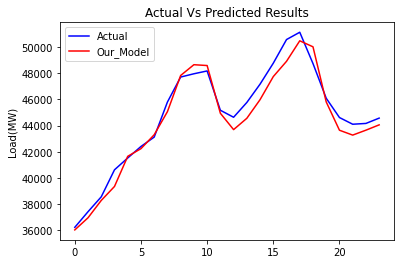

In [19]:
pyplot.plot(actual[:24], label='Actual', color="blue")
pyplot.plot(predicted[:24], label='Our_Model', color="red")
pyplot.ylabel("Load(MW)")
pyplot.title("Actual Vs Predicted Results")
pyplot.legend()
pyplot.show()